100%|██████████| 562M/562M [00:09<00:00, 58.6MB/s] 
d:\python\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--- Evaluating Checkpoint at Epoch 50 (1 random-seed run) ---
Checkpoint at epoch 50 loaded successfully!

--- Random Seed for this run: 23 ---


d:\python\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Sampling: 0it [00:00, ?it/s]

[Epoch 50] Seed: 23, SSIM: 0.3741, FID: 0.0054, IS: 1.7646


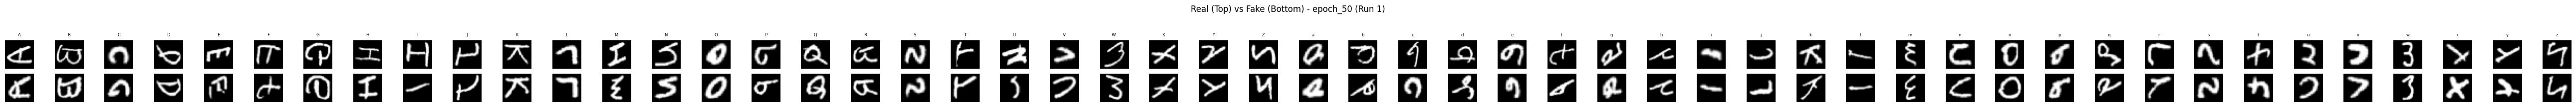

Label-aligned samples for epoch_50, run 1 saved to emnist_evaluation_epoch_50_random_seed/label_aligned_samples_epoch_50_run_1.png.
Evaluation for epoch 50 completed.


In [1]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import EMNIST
from torchvision import transforms
from diffusers import UNet2DModel, DDPMScheduler
from accelerate import Accelerator
from PIL import Image
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch.nn.functional as F
from tqdm.auto import tqdm
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# === 1. Set Current Epoch ===
current_epoch = 50 # Set the epoch you want to evaluate

# === 2. Dataset Setup ===
class RemapLabels(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.label_map[y]

    def __len__(self):
        return len(self.subset)

def get_letter_emnist_dataset():
    full_dataset = EMNIST(
        "./data",
        split="byclass",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    )
    valid_labels = list(range(10, 62))  # A-Z (10-35), a-z (36-61)
    indices = [i for i, (_, label) in enumerate(full_dataset) if label in valid_labels]
    label_map = {orig: new for new, orig in enumerate(valid_labels)}
    subset = Subset(full_dataset, indices)
    return RemapLabels(subset, label_map), [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

dataset, class_labels = get_letter_emnist_dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
num_classes = len(class_labels)

# Output folder
output_dir = f"emnist_evaluation_epoch_{current_epoch}_random_seed"
os.makedirs(output_dir, exist_ok=True)

with open(f"{output_dir}/class_map.json", "w") as f:
    json.dump(class_labels, f)

# === 3. Model Configuration ===
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0001,
    beta_end=0.02
)
base_model_config = {
    "sample_size": 28,
    "in_channels": 1,
    "out_channels": 1,
    "layers_per_block": 2,
    "block_out_channels": (32, 64, 128),
    "down_block_types": ("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    "up_block_types": ("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    "class_embed_type": "timestep",
    "num_class_embeds": num_classes,
}
def create_model(config):
    return UNet2DModel(**config)

# === 4. Accelerator Setup ===
accelerator = Accelerator(mixed_precision="fp16")
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(accelerator.device)
fid_metric = FrechetInceptionDistance(feature=64).to(accelerator.device)
is_metric = InceptionScore().to(accelerator.device)

# === Helper Functions ===
def generate_batch_samples(model, scheduler, num_classes, device):
    model.eval()
    all_labels = torch.arange(num_classes, device=device)
    noise = torch.randn((num_classes, 1, 28, 28), device=device)
    for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Sampling"):
        t_batch = torch.full((num_classes,), t, device=device)
        with torch.no_grad():
            noise_pred = model(noise, t_batch, all_labels).sample
        noise = scheduler.step(noise_pred, t, noise).prev_sample
    images = (noise.clamp(-1, 1) + 1) * 0.5
    return images, all_labels

def get_label_ordered_real_images(dataloader, num_classes, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    ordered = {}
    data_iter = iter(dataloader)
    while len(ordered) < num_classes:
        try:
            images, labels = next(data_iter)
            for img, label in zip(images, labels):
                label = label.item()
                if label not in ordered:
                    ordered[label] = img
                    if len(ordered) == num_classes:
                        break
        except StopIteration:
            data_iter = iter(dataloader)
    ordered_images = [ordered[i] for i in range(num_classes)]
    return torch.stack(ordered_images)

def show_label_aligned_images(fake_images, fake_labels, real_images, class_labels, run, epoch_tag="epoch_10"):
    num_classes = len(class_labels)
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes, 2))
    for i in range(num_classes):
        axes[0, i].imshow(real_images[i][0].cpu(), cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(class_labels[i], fontsize=6)

        axes[1, i].imshow(fake_images[i][0].cpu(), cmap="gray")
        axes[1, i].axis("off")

    plt.suptitle(f"Real (Top) vs Fake (Bottom) - {epoch_tag} (Run {run})", y=1.05)
    plt.tight_layout()
    filename = f"{output_dir}/label_aligned_samples_{epoch_tag}_run_{run}.png"
    plt.savefig(filename)
    plt.show()
    print(f"Label-aligned samples for {epoch_tag}, run {run} saved to {filename}.")

def save_individual_samples(fake_images, fake_labels, class_labels, epoch, run, output_dir):
    os.makedirs(f"{output_dir}/run_{run}", exist_ok=True)
    for img, label in zip(fake_images, fake_labels):
        label = label.item()
        char = class_labels[label]
        case = 'u' if char.isupper() else 'l'
        filename = f"{output_dir}/run_{run}/{epoch}_{char}_{case}.png"
        img_pil = transforms.ToPILImage()(img.cpu())
        img_pil.save(filename)

def evaluate_metrics(fake_images, fake_labels, real_images, ssim_metric, fid_metric, is_metric, device):
    real_images = (real_images + 1) / 2.0
    if real_images.ndim == 3:
        real_images = real_images[:, None]
    if fake_images.ndim == 3:
        fake_images = fake_images[:, None]
    ssim_score = ssim_metric(fake_images.to(device), real_images.to(device)).item()
    fake_images_metric = preprocess_for_metrics(fake_images)
    real_images_metric = preprocess_for_metrics(real_images)
    fid_metric.reset()
    is_metric.reset()
    fid_metric.update(real_images_metric.to(device), real=True)
    fid_metric.update(fake_images_metric.to(device), real=False)
    fid_score = fid_metric.compute().item()
    is_metric.update(fake_images_metric.to(device))
    is_score, _ = is_metric.compute()
    is_score = is_score.item()
    return ssim_score, fid_score, is_score

def preprocess_for_metrics(imgs):
    imgs = ((imgs + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    if imgs.shape[1] == 1:
        imgs = imgs.repeat(1, 3, 1, 1)
    imgs = F.interpolate(imgs.float(), size=(299, 299), mode="bilinear", align_corners=False)
    return imgs.to(torch.uint8)

def load_checkpoint(accelerator, epoch):
    checkpoint_path = f"emnist_diffusion_model/epoch_{epoch}"
    if os.path.exists(checkpoint_path):
        accelerator.load_state(checkpoint_path)
        print(f"Checkpoint at epoch {epoch} loaded successfully!")
        return True
    else:
        print(f"No checkpoint found at {checkpoint_path}. Skipping evaluation for this epoch.")
        return False

# === 5. Evaluation Start ===
print(f"\n--- Evaluating Checkpoint at Epoch {current_epoch} (1 random-seed run) ---")
evaluation_results = []

# Create model
model = create_model(base_model_config)
model = accelerator.prepare(model)
unwrapped_model = accelerator.unwrap_model(model)

if load_checkpoint(accelerator, current_epoch):

    seed = 23

    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"\n--- Random Seed for this run: {seed} ---")

    
    real_images = get_label_ordered_real_images(dataloader, num_classes, seed)

    
    fake_images, fake_labels = generate_batch_samples(unwrapped_model, noise_scheduler, num_classes, accelerator.device)

    
    save_individual_samples(fake_images, fake_labels, class_labels, current_epoch, 1, output_dir)

    
    ssim_score, fid_score, is_score = evaluate_metrics(
        fake_images, fake_labels, real_images,
        ssim_metric, fid_metric, is_metric,
        accelerator.device
    )
    evaluation_results.append({
        "epoch": current_epoch,
        "seed": seed,
        "ssim": ssim_score,
        "fid": fid_score,
        "is": is_score
    })
    print(f"[Epoch {current_epoch}] Seed: {seed}, SSIM: {ssim_score:.4f}, FID: {fid_score:.4f}, IS: {is_score:.4f}")

    
    show_label_aligned_images(fake_images, fake_labels, real_images, class_labels, run=1, epoch_tag=f"epoch_{current_epoch}")

  
    metrics_filename = f"{output_dir}/evaluation_metrics_epoch_{current_epoch}_random_seed.csv"
    metrics_df = pd.DataFrame(evaluation_results)
    metrics_df.to_csv(metrics_filename, index=False)

else:
    print(f"Evaluation for epoch {current_epoch} could not be performed.")

accelerator.end_training()
print(f"Evaluation for epoch {current_epoch} completed.")
